In [1]:
import numpy as np
from scipy.optimize import curve_fit
import pylab
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import scipy.stats
from sklearn import metrics
import tensorflow as tf
import seaborn as sns


2023-05-12 21:53:51.757166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import geopandas as gpd
from shapely import wkt

In [3]:
import warnings
warnings.filterwarnings('ignore')

**Data Cleaning**

In [4]:
listings = pd.read_csv("listings.csv")

In [7]:
listings['review_scores_rating']

0         NaN
1        4.85
2         NaN
3        5.00
4        4.48
         ... 
42926     NaN
42927    4.48
42928    4.43
42929     NaN
42930    4.65
Name: review_scores_rating, Length: 42931, dtype: float64

In [16]:
listings_review = listings_clean[['review_scores_rating', 'price']]

In [17]:
listings_review = listings_review.dropna()

In [18]:
listings_review.corr()

,review_scores_rating,price
review_scores_rating,1.000000,0.070572
price,0.070572,1.000000


In [22]:
listings_review

,review_scores_rating,price
1,4.85,30.0
3,5.00,89.0
4,4.48,125.0
5,4.68,63.0
7,5.00,118.0
...,...,...
42221,5.00,150.0
42224,4.98,350.0
42226,4.48,208.0
42227,4.43,125.0


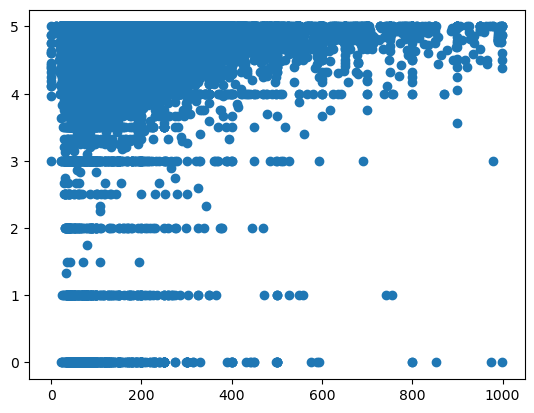

In [19]:
plt.scatter(listings_review['price'], listings_review['review_scores_rating'])

In [23]:
standard_scaler = preprocessing.StandardScaler() 
x_scaled = standard_scaler.fit_transform(listings_review)
newX = pd.DataFrame(x_scaled)

In [25]:
newX.corr()

,0,1
0,1.000000,0.070572
1,0.070572,1.000000


In [90]:
listings.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 
       'amenities', 'calendar_updated', 'has_availability', 'calendar_last_scraped', 'first_review',
       'last_review', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'
       ], inplace=True)

listings.drop(columns=['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month','bathrooms'], inplace=True)
listings.dropna(inplace=True)
listings.isnull().sum()


neighbourhood                   0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms_text                  0
bedrooms                        0
beds                            0
price                           0
minimum_nights                  0
maximum_nights                  0
minimum_minimum_nights          0
maximum_minimum_nights          0
minimum_maximum_nights          0
maximum_maximum_nights          0
minimum_nights_avg_ntm          0
maximum_nights_avg_ntm          0
availability_30                 0
availability_60                 0
availability_90                 0
availability_365                0
number_of_reviews               0
number_of_reviews_ltm           0
number_of_reviews_l30d          0
dtype: int64

In [91]:
def convert(text):
    if text[0].isnumeric():
        return float(text.split(" ")[0])
    else:
        return 1.0    #"shared"
listings["bathrooms"] = listings["bathrooms_text"].apply(convert)
listings.drop(columns='bathrooms_text', inplace=True)

In [15]:
#cast price into float
listings["price"] = listings["price"].str[1:].str.replace(",","").astype("float")
listings = listings[listings.price < 1000]

listings_clean = listings.copy()
listings_clean.reset_index(inplace=True)
listings_clean.drop(columns='index', inplace=True)


In [93]:
listings['price'].mean(), listings[listings.price > 1000].count()[0]

(166.7591829340097, 0)

In [94]:
listings_clean = pd.get_dummies(data=listings_clean, prefix=['nbh', 'pt', 'rt'], columns=['neighbourhood_cleansed', 'property_type', 'room_type'])
listings_clean



,neighbourhood,neighbourhood_group_cleansed,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,pt_Shared room in home,pt_Shared room in loft,pt_Shared room in rental unit,pt_Shared room in serviced apartment,pt_Shared room in townhouse,pt_Tiny home,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room
0,"The Bronx, New York, United States",Bronx,40.903260,-73.907090,3,2.0,2.0,125.0,3,21,...,0,0,0,0,0,0,1,0,0,0
1,"Queens, New York, United States",Queens,40.763500,-73.826080,3,1.0,1.0,63.0,2,365,...,0,0,0,0,0,0,0,0,1,0
2,"RIVERDALE, New York, United States",Bronx,40.882320,-73.906210,4,2.0,2.0,115.0,30,1125,...,0,0,0,0,0,0,1,0,0,0
3,"Queens, New York, United States",Queens,40.709585,-73.746119,4,3.0,5.0,179.0,1,1125,...,0,0,0,0,0,0,1,0,0,0
4,"Queens, New York, United States",Queens,40.596000,-73.771140,6,2.0,3.0,380.0,1,1125,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22074,"Brooklyn, New York, United States",Brooklyn,40.698330,-73.932630,1,1.0,1.0,50.0,30,31,...,0,0,0,0,0,0,0,0,1,0
22075,"Brooklyn, New York, United States",Brooklyn,40.675660,-73.965490,2,1.0,1.0,74.0,30,1125,...,0,0,0,0,0,0,0,0,1,0
22076,"Staten Island, New York, United States",Staten Island,40.579550,-74.110330,1,1.0,1.0,33.0,30,1125,...,0,0,0,0,0,0,0,0,1,0
22077,"New York, United States",Manhattan,40.778103,-73.985179,12,4.0,9.0,857.0,4,365,...,0,0,0,0,0,0,1,0,0,0


**Exploratory Data Analysis**

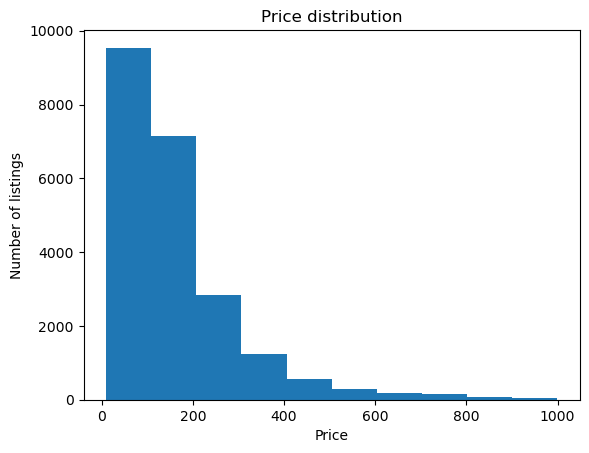

In [95]:
plt.hist(listings_clean.price)
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

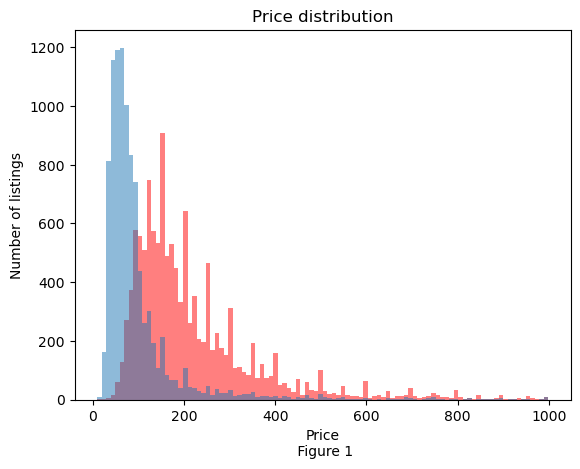

In [96]:
plt.hist(listings_clean[listings_clean["rt_Entire home/apt"] == 1].price, bins = 100, color = 'red', alpha = 0.5, label = "entire home")
plt.hist(listings_clean[listings_clean["rt_Entire home/apt"] == 0].price, bins = 100, alpha = 0.5, label = "entire home")
plt.title("Price distribution")
plt.xlabel("Price\n Figure 1")
plt.ylabel("Number of listings")
plt.show()

In [97]:
listings_clean

,neighbourhood,neighbourhood_group_cleansed,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,pt_Shared room in home,pt_Shared room in loft,pt_Shared room in rental unit,pt_Shared room in serviced apartment,pt_Shared room in townhouse,pt_Tiny home,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room
0,"The Bronx, New York, United States",Bronx,40.903260,-73.907090,3,2.0,2.0,125.0,3,21,...,0,0,0,0,0,0,1,0,0,0
1,"Queens, New York, United States",Queens,40.763500,-73.826080,3,1.0,1.0,63.0,2,365,...,0,0,0,0,0,0,0,0,1,0
2,"RIVERDALE, New York, United States",Bronx,40.882320,-73.906210,4,2.0,2.0,115.0,30,1125,...,0,0,0,0,0,0,1,0,0,0
3,"Queens, New York, United States",Queens,40.709585,-73.746119,4,3.0,5.0,179.0,1,1125,...,0,0,0,0,0,0,1,0,0,0
4,"Queens, New York, United States",Queens,40.596000,-73.771140,6,2.0,3.0,380.0,1,1125,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22074,"Brooklyn, New York, United States",Brooklyn,40.698330,-73.932630,1,1.0,1.0,50.0,30,31,...,0,0,0,0,0,0,0,0,1,0
22075,"Brooklyn, New York, United States",Brooklyn,40.675660,-73.965490,2,1.0,1.0,74.0,30,1125,...,0,0,0,0,0,0,0,0,1,0
22076,"Staten Island, New York, United States",Staten Island,40.579550,-74.110330,1,1.0,1.0,33.0,30,1125,...,0,0,0,0,0,0,0,0,1,0
22077,"New York, United States",Manhattan,40.778103,-73.985179,12,4.0,9.0,857.0,4,365,...,0,0,0,0,0,0,1,0,0,0


In [98]:
price_neigh = listings_clean.groupby(by = 'neighbourhood_group_cleansed').mean()[['price']].reset_index()
price_neigh.rename(columns = {'neighbourhood_group_cleansed': 'neighbourhood'})


,neighbourhood,price
0,Bronx,105.673446
1,Brooklyn,146.524533
2,Manhattan,221.442695
3,Queens,114.118753
4,Staten Island,124.673820


In [99]:
 listings_clean.groupby(by = 'neighbourhood_group_cleansed').count().reset_index()['neighbourhood']
    
    

0     885
1    8886
2    8193
3    3882
4     233
Name: neighbourhood, dtype: int64

In [100]:
price_neigh['count'] =  listings_clean.groupby(by = 'neighbourhood_group_cleansed').count().reset_index()['neighbourhood']





In [101]:
price_neigh

,neighbourhood_group_cleansed,price,count
0,Bronx,105.673446,885
1,Brooklyn,146.524533,8886
2,Manhattan,221.442695,8193
3,Queens,114.118753,3882
4,Staten Island,124.673820,233


In [102]:
np.median(listings_clean.price)

125.0

In [103]:
listings_clean = listings_clean.drop(columns = 'neighbourhood_group_cleansed')

In [104]:
listings_clean = listings_clean.drop(index=listings_clean.iloc[2793].name)

In [105]:
listings_clean = listings_clean.drop(columns = "rt_Entire home/apt")

In [106]:
nbhoods = pd.read_csv('nynta.csv')
nbhoods.rename(columns={'NTAName':'neighbourhood'}, inplace=True)

#Then, since this is a csv file, convert the geometry column text into well known text, this will allow you to plot its geometry correctly
nbhoods['geom'] = nbhoods['the_geom'].apply(wkt.loads)

#Now convert the pandas dataframe into a Geopandas GeoDataFrame
nbhoods = gpd.GeoDataFrame(nbhoods, geometry='geom')

In [107]:
data = gpd.GeoDataFrame(listings_clean, geometry=gpd.points_from_xy(listings_clean.longitude, listings_clean.latitude))



In [108]:
joined = gpd.sjoin(nbhoods, data, how='inner', op='intersects')
joined.drop(columns='geom', inplace=True)


In [109]:
joined['price']

0      164.0
0       81.0
0      125.0
0      121.0
0      200.0
       ...  
194     83.0
194     45.0
194     50.0
194    115.0
194     75.0
Name: price, Length: 22077, dtype: float64

In [110]:
#Rename the column. 
joined.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

#Create a count of each neighborhood
nb_join_count = joined.groupby('neighbourhood').count().reset_index()

In [111]:
nb_join_price = joined.groupby('neighbourhood')['price'].mean().reset_index()

In [112]:
nb_join_price

,neighbourhood,price
0,Airport,188.000000
1,Allerton-Pelham Gardens,119.391304
2,Annadale-Huguenot-Prince's Bay-Eltingville,111.666667
3,Arden Heights,141.500000
4,Astoria,109.940260
...,...,...
187,Yorkville,190.000000
188,park-cemetery-etc-Bronx,163.800000
189,park-cemetery-etc-Brooklyn,147.318182
190,park-cemetery-etc-Manhattan,132.680000


In [113]:
true_count = nbhoods.merge(nb_join_count, on='neighbourhood')

In [114]:
true_price = nbhoods.merge(nb_join_price, on='neighbourhood')

In [115]:
true_count

,the_geom_x,BoroCode_x,BoroName_x,CountyFIPS_x,NTACode_x,neighbourhood,Shape_Leng_x,Shape_Area_x,geom,the_geom_y,...,pt_Shared room in guesthouse,pt_Shared room in home,pt_Shared room in loft,pt_Shared room in rental unit,pt_Shared room in serviced apartment,pt_Shared room in townhouse,pt_Tiny home,rt_Hotel room,rt_Private room,rt_Shared room
0,MULTIPOLYGON (((-73.75205066516907 40.70522802...,4,Queens,81,QN08,St. Albans,45401.316803,7.741275e+07,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",108,...,108,108,108,108,108,108,108,108,108,108
1,MULTIPOLYGON (((-73.8870514253612 40.884349575...,2,Bronx,5,BX28,Van Cortlandt Village,21945.719299,2.566612e+07,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ...",21,...,21,21,21,21,21,21,21,21,21,21
2,MULTIPOLYGON (((-73.80576840191371 40.68293239...,4,Queens,81,QN55,South Ozone Park,36708.169305,8.246139e+07,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ...",62,...,62,62,62,62,62,62,62,62,62,62
3,MULTIPOLYGON (((-73.98017161103701 40.66115465...,3,Brooklyn,47,BK40,Windsor Terrace,19033.672066,1.404167e+07,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ...",86,...,86,86,86,86,86,86,86,86,86,86
4,MULTIPOLYGON (((-73.88833929256353 40.64671022...,3,Brooklyn,47,BK50,Canarsie,43703.609666,8.208968e+07,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",148,...,148,148,148,148,148,148,148,148,148,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,MULTIPOLYGON (((-73.90129277627032 40.82047544...,2,Bronx,5,BX34,Melrose South-Mott Haven North,19589.196431,1.727176e+07,"MULTIPOLYGON (((-73.90129 40.82048, -73.90160 ...",22,...,22,22,22,22,22,22,22,22,22,22
188,MULTIPOLYGON (((-73.89680883223774 40.79580844...,2,Bronx,5,BX39,Mott Haven-Port Morris,35604.790810,4.189861e+07,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",105,...,105,105,105,105,105,105,105,105,105,105
189,MULTIPOLYGON (((-73.9119181232027 40.843257886...,2,Bronx,5,BX63,West Concourse,28571.879354,1.936642e+07,"MULTIPOLYGON (((-73.91192 40.84326, -73.91195 ...",34,...,34,34,34,34,34,34,34,34,34,34
190,MULTIPOLYGON (((-74.072581339395 40.6379418745...,5,Staten Island,85,SI22,West New Brighton-New Brighton-St. George,66052.593065,5.602857e+07,"MULTIPOLYGON (((-74.07258 40.63794, -74.07330 ...",39,...,39,39,39,39,39,39,39,39,39,39


Text(0.5, 1.0, 'Number of Airbnb listings by Neighborhood in NYC')

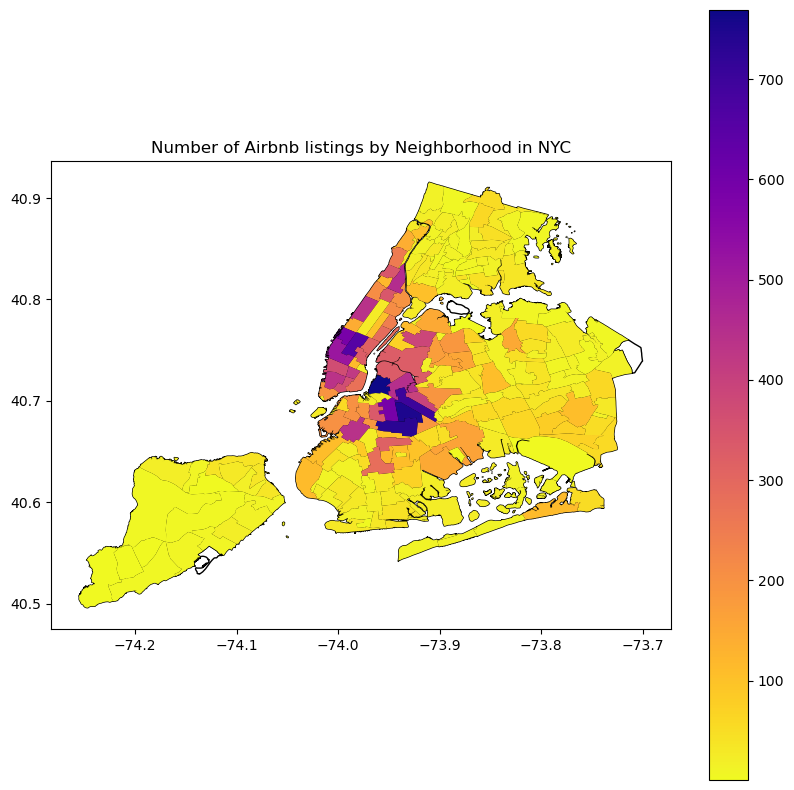

In [116]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nbhoods.plot(color='white', edgecolor='black', ax=ax)

true_count.plot(column='the_geom_y',cmap='plasma_r', ax=base, legend=True)
plt.title('Number of Airbnb listings by Neighborhood in NYC')

Text(0.5, 1.0, 'Price of Airbnb listings by Neighborhood in NYC')

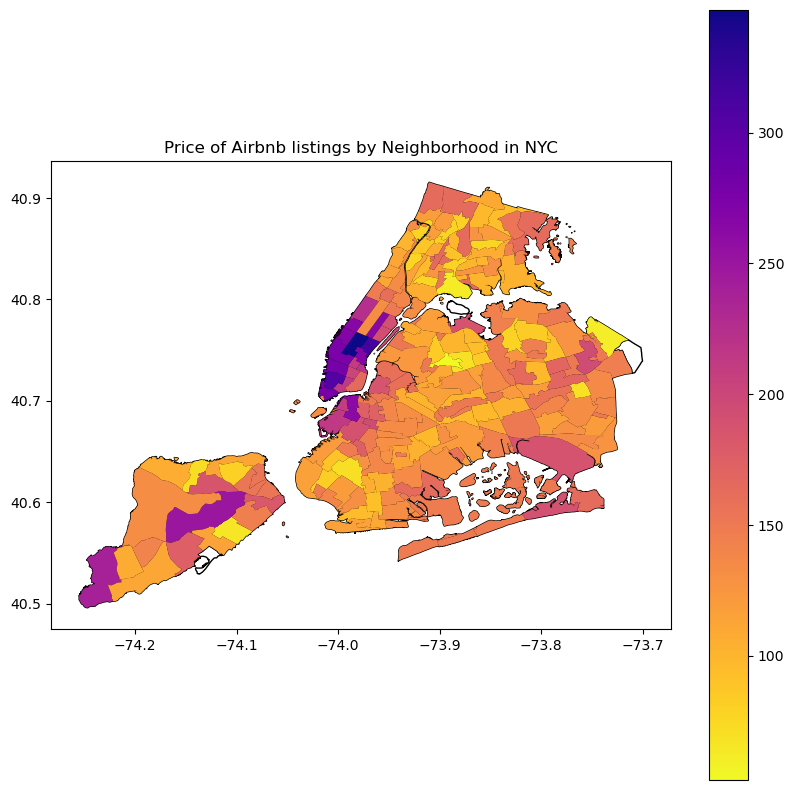

In [117]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nbhoods.plot(color='white', edgecolor='black', ax=ax)

true_price.plot(column='price',cmap='plasma_r', ax=base, legend=True)
plt.title('Price of Airbnb listings by Neighborhood in NYC')

In [118]:
listings

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,...,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,bathrooms
4,"The Bronx, New York, United States",North Riverdale,Bronx,40.903260,-73.907090,Entire rental unit,Entire home/apt,3,2.0,2.0,...,3.0,21.0,3,17,46,46,25,16,0,1.0
5,"Queens, New York, United States",Flushing,Queens,40.763500,-73.826080,Private room in rental unit,Private room,3,1.0,1.0,...,2.0,1125.0,14,44,74,349,40,34,0,1.0
9,"RIVERDALE, New York, United States",Kingsbridge,Bronx,40.882320,-73.906210,Entire rental unit,Entire home/apt,4,2.0,2.0,...,30.0,1125.0,18,48,78,209,16,0,0,1.0
11,"Queens, New York, United States",Queens Village,Queens,40.709585,-73.746119,Entire home,Entire home/apt,4,3.0,5.0,...,1.0,1125.0,27,54,84,359,2,2,2,1.0
15,"Queens, New York, United States",Edgemere,Queens,40.596000,-73.771140,Entire home,Entire home/apt,6,2.0,3.0,...,1.0,1125.0,30,60,88,346,8,8,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42911,"Brooklyn, New York, United States",Bushwick,Brooklyn,40.698330,-73.932630,Private room in rental unit,Private room,1,1.0,1.0,...,30.0,31.0,0,0,0,0,10,0,0,1.0
42915,"Brooklyn, New York, United States",Prospect Heights,Brooklyn,40.675660,-73.965490,Private room in rental unit,Private room,2,1.0,1.0,...,30.0,1125.0,0,0,0,0,24,0,0,1.0
42917,"Staten Island, New York, United States",Grant City,Staten Island,40.579550,-74.110330,Private room in rental unit,Private room,1,1.0,1.0,...,30.0,1125.0,0,0,0,82,7,3,0,1.0
42920,"New York, United States",Upper West Side,Manhattan,40.778103,-73.985179,Entire guesthouse,Entire home/apt,12,4.0,9.0,...,9.3,683.1,5,12,22,214,47,34,1,3.0


<AxesSubplot:>

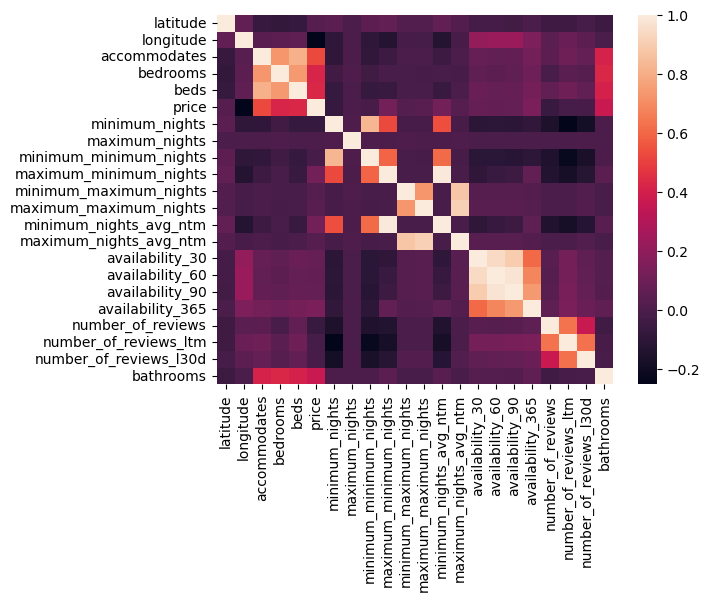

In [119]:
sns.heatmap(listings.drop(columns = ['neighbourhood', 'neighbourhood_cleansed','property_type','room_type']).corr())



In [120]:
listings.drop(columns = ['neighbourhood', 'neighbourhood_cleansed','property_type','room_type']).corr()

,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,...,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,bathrooms
latitude,1.000000,0.065097,-0.071027,-0.084418,-0.076113,0.029283,0.042584,-0.004667,0.046479,0.060963,...,0.061782,0.017335,-0.023874,-0.023464,-0.029590,-0.005221,-0.044039,-0.044464,-0.018615,-0.049036
longitude,0.065097,1.000000,0.035696,0.049430,0.060236,-0.252263,-0.098610,-0.004628,-0.099731,-0.133294,...,-0.132131,-0.015940,0.209389,0.229149,0.230615,0.146118,0.041463,0.089593,0.048986,-0.003100
accommodates,-0.071027,0.035696,1.000000,0.726143,0.810497,0.524703,-0.094403,-0.000118,-0.086459,-0.054450,...,-0.055668,-0.002271,0.077980,0.063835,0.069274,0.117569,0.050041,0.099840,0.073527,0.408797
bedrooms,-0.084418,0.049430,0.726143,1.000000,0.738563,0.422508,-0.035534,0.005477,-0.037134,-0.008955,...,-0.010572,-0.013211,0.057663,0.050391,0.059493,0.103586,-0.008733,0.043855,0.031305,0.431405
beds,-0.076113,0.060236,0.810497,0.738563,1.000000,0.427910,-0.074210,-0.004311,-0.074398,-0.061822,...,-0.064133,-0.007632,0.085766,0.071481,0.076857,0.120951,0.061603,0.095337,0.061275,0.404794
price,0.029283,-0.252263,0.524703,0.422508,0.427910,1.000000,-0.072991,0.000313,-0.014166,0.118353,...,0.116651,0.030315,0.077936,0.069652,0.074260,0.138599,-0.065043,-0.020617,-0.014111,0.366421
minimum_nights,0.042584,-0.098610,-0.094403,-0.035534,-0.074210,-0.072991,1.000000,0.004036,0.825598,0.522767,...,0.535484,-0.014298,-0.109296,-0.102464,-0.110154,-0.088052,-0.158411,-0.251885,-0.185154,0.002008
maximum_nights,-0.004667,-0.004628,-0.000118,0.005477,-0.004311,0.000313,0.004036,1.000000,0.003340,0.001401,...,0.001535,0.002538,-0.005994,-0.006487,-0.006906,-0.006975,-0.003747,-0.003655,-0.002584,-0.002546
minimum_minimum_nights,0.046479,-0.099731,-0.086459,-0.037134,-0.074398,-0.014166,0.825598,0.003340,1.000000,0.593667,...,0.613337,-0.013791,-0.114403,-0.111672,-0.119591,-0.104282,-0.149259,-0.224543,-0.164932,-0.001172
maximum_minimum_nights,0.060963,-0.133294,-0.054450,-0.008955,-0.061822,0.118353,0.522767,0.001401,0.593667,1.000000,...,0.993165,-0.009264,-0.093041,-0.063771,-0.048434,0.064061,-0.139025,-0.174471,-0.124516,0.042258


**Model**

In [121]:
from sklearn.model_selection import train_test_split


In [122]:
X = listings_clean.drop(columns = ['price','geometry','neighbourhood'])
y = listings_clean[['price']]

In [123]:
X

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,...,pt_Shared room in guesthouse,pt_Shared room in home,pt_Shared room in loft,pt_Shared room in rental unit,pt_Shared room in serviced apartment,pt_Shared room in townhouse,pt_Tiny home,rt_Hotel room,rt_Private room,rt_Shared room
0,40.903260,-73.907090,3,2.0,2.0,3,21,3.0,3.0,21.0,...,0,0,0,0,0,0,0,0,0,0
1,40.763500,-73.826080,3,1.0,1.0,2,365,2.0,2.0,1125.0,...,0,0,0,0,0,0,0,0,1,0
2,40.882320,-73.906210,4,2.0,2.0,30,1125,30.0,30.0,1125.0,...,0,0,0,0,0,0,0,0,0,0
3,40.709585,-73.746119,4,3.0,5.0,1,1125,1.0,1.0,1125.0,...,0,0,0,0,0,0,0,0,0,0
4,40.596000,-73.771140,6,2.0,3.0,1,1125,1.0,1.0,1125.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22074,40.698330,-73.932630,1,1.0,1.0,30,31,30.0,30.0,31.0,...,0,0,0,0,0,0,0,0,1,0
22075,40.675660,-73.965490,2,1.0,1.0,30,1125,30.0,30.0,1125.0,...,0,0,0,0,0,0,0,0,1,0
22076,40.579550,-74.110330,1,1.0,1.0,30,1125,30.0,30.0,1125.0,...,0,0,0,0,0,0,0,0,1,0
22077,40.778103,-73.985179,12,4.0,9.0,4,365,3.0,30.0,365.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from sklearn import preprocessing

In [125]:
standard_scaler = preprocessing.StandardScaler() 

In [126]:
len(X.columns)

299

In [127]:
original_features = X.columns[:21]
original_features

Index(['latitude', 'longitude', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'bathrooms'],
      dtype='object')

In [128]:
x = X[original_features]
x_scaled = standard_scaler.fit_transform(x)
newX = pd.DataFrame(x_scaled)
X[original_features] = newX
X = X.dropna()

In [129]:
X.shape

(22077, 299)

In [130]:
y = y[:22077]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,
                                                    random_state=42)



In [132]:
X_train.shape

(17661, 299)

In [133]:
y_train.shape

(17661, 1)

KNN Model

In [201]:
from sklearn.neighbors import KNeighborsClassifier


In [202]:
lst = []
for i in range(10,35):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    lst = np.append(lst,np.sum(np.abs(neigh.predict(X_test) - y_test['price']))/len(y_test))

Text(0, 0.5, 'MAE')

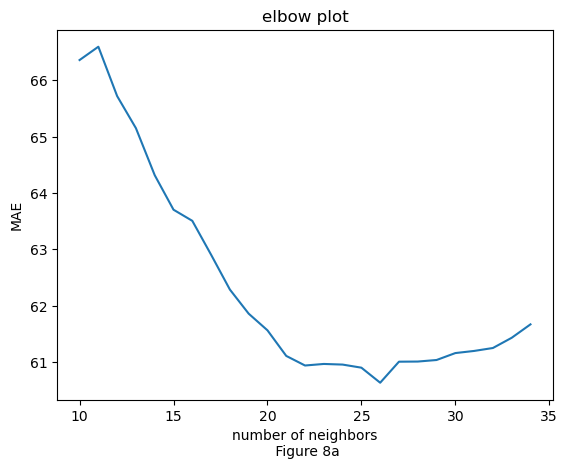

In [208]:
plt.plot(np.arange(10,35), lst)
plt.title("elbow plot")
plt.xlabel("number of neighbors\n Figure 8a")
plt.ylabel("MAE")

In [204]:
lst

array([66.3584692 , 66.5946558 , 65.71897645, 65.14945652, 64.31612319,
       63.7040308 , 63.50701993, 62.90602355, 62.28826993, 61.8607337 ,
       61.56544384, 61.11141304, 60.94112319, 60.96875   , 60.95765399,
       60.90262681, 60.63586957, 61.00883152, 61.01132246, 61.03872283,
       61.16168478, 61.19950181, 61.25158514, 61.43274457, 61.6709692 ])

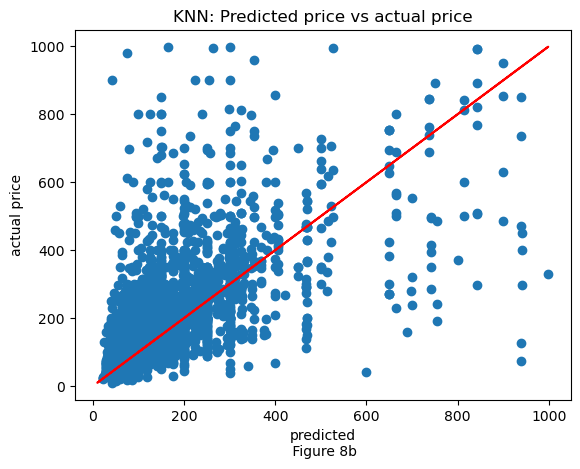

In [209]:
plt.scatter(neigh.predict(X_test), y_test['price'])
plt.title("KNN: Predicted price vs actual price")
plt.xlabel("predicted\n Figure 8b")
plt.ylabel("actual price")
plt.plot(y_test['price'],y_test['price'], color = 'r')

In [206]:
lst

array([66.3584692 , 66.5946558 , 65.71897645, 65.14945652, 64.31612319,
       63.7040308 , 63.50701993, 62.90602355, 62.28826993, 61.8607337 ,
       61.56544384, 61.11141304, 60.94112319, 60.96875   , 60.95765399,
       60.90262681, 60.63586957, 61.00883152, 61.01132246, 61.03872283,
       61.16168478, 61.19950181, 61.25158514, 61.43274457, 61.6709692 ])

Neural Network

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import *  

In [136]:
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanAbsoluteError

In [137]:
hidden_units1 = 256
hidden_units2 = 128
hidden_units3 = 64
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),        
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
    return model
# build the model
model = build_model_using_sequential()

In [138]:
mae = MeanAbsoluteError()
model.compile(
    loss=mae, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[mae]
)
# train the model
history = model.fit(
    X_train.values, 
    y_train.values, 
    epochs=10, 
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
221/221 [==============================] - 2s 5ms/step - loss: 72.4955 - mean_absolute_error: 72.5027 - val_loss: 66.3216 - val_mean_absolute_error: 65.8041
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 65.4733 - mean_absolute_error: 65.4701 - val_loss: 62.9691 - val_mean_absolute_error: 62.5558
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 64.9676 - mean_absolute_error: 64.9596 - val_loss: 63.6578 - val_mean_absolute_error: 63.2461
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 63.7878 - mean_absolute_error: 63.8347 - val_loss: 62.8893 - val_mean_absolute_error: 62.5493
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 63.7414 - mean_absolute_error: 63.7354 - val_loss: 63.1476 - val_mean_absolute_error: 62.7168
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 63.0769 - mean_absolute_error: 63.0656 - val_loss: 64.2858 - val_mean_absolute_error: 

In [139]:
predictions = model.predict(X_test)


138/138 [==============================] - 0s 2ms/step


In [140]:
y_pred = pd.DataFrame(data = predictions)

In [141]:
y_pred[0]

0       109.939110
1        74.918198
2        73.638733
3        69.514648
4       169.111603
           ...    
4411    215.069794
4412    132.885208
4413    147.872192
4414     91.528786
4415    208.375076
Name: 0, Length: 4416, dtype: float32

In [142]:
y_test = y_test.reset_index()

In [143]:
np.abs(y_pred[0] - y_test['price']).median()

33.17915344238281

In [150]:
np.sqrt(np.sum((y_pred[0] - y_test['price'])**2/ y_test['price']**2))/np.mean(y_test['price'])



0.2067829106167597

Text(0.5, 1.0, 'Neural Network: predicted vs original')

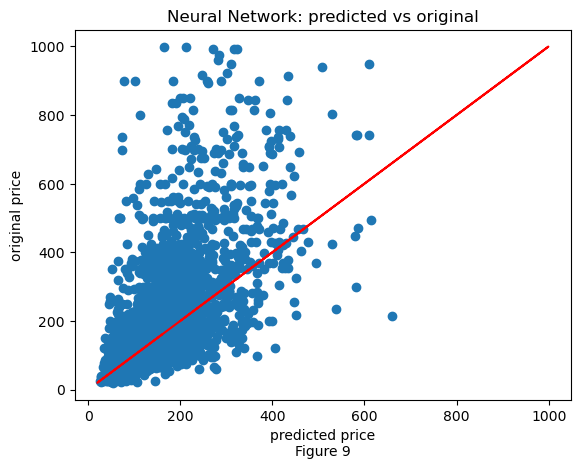

In [301]:
plt.scatter(y_pred[0], y_test['price'])
plt.plot(y_test['price'],y_test['price'], color = 'red')
plt.xlabel("predicted price\nFigure 9")
plt.ylabel("original price")
plt.title("Neural Network: predicted vs original")

In [303]:
from sklearn.decomposition import PCA

In [304]:
from sklearn.metrics import r2_score

model = PCA(n_components=2).fit(X_train)
print(model.explained_variance_ratio_.sum())
print(r2_score(X_train, model.inverse_transform(model.transform(X_train)),
               multioutput='variance_weighted'))
print(r2_score(X_test, model.inverse_transform(model.transform(X_test)),
               multioutput='variance_weighted'))

0.30538458158823434
0.30538458158823656
0.2271114166545269


In [307]:
from sklearn.metrics import r2_score

In [308]:
r2_score(y_test['price'], y_pred[0])

0.40096706249208003